## Cluster creation

Let us go throught the various ways you can define a cluster.
In the end you only need $N$ 2D vectors, i.e. the positions of the particles. 
Depending on what you want to do (your protocol and aim), there might be better ways to obtain these.

In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt

from tool_create_cluster import rotate, add_basis
# Various shapes
from tool_create_cluster import create_cluster_circle, create_cluster_hex, create_cluster_rect, create_cluster_tri, create_cluster_special
from tool_create_cluster import create_input_hex, load_input_hex

def plt_cosmetic(ax):
    ax.axhline(color='gray', ls=':', lw=1)
    ax.axvline(color='gray', ls=':', lw=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

### Set up lattice and size

Define a parent lattice: the cluster will be a (connected) subset of points of this lattice.
The lattice is defined in a ```.hex``` file containing:
- number of repetitions $N_1$, $N_2$ along the two lattice directions;
- the lattice vectors $\bf{a}_1$, $\bf{a}_2$.

This file is loaded by the functions creating different shapes: the lattice is created up to $N_1$, $N_2$ and then cut according to the shape, e.g. for a circle the distance of the lattice point $i$ from the origin $R_i$ is less than the radius $R=|| N_1 \bf{a}_1 + N_2 \bf{a_2}||$

In [2]:
N1, N2 = 5, 10
a1, a2 = [1, 0], [-1/2, sqrt(3)/2] # triangular

from tool_create_cluster import cluster_inhex_Nl
create_input_hex(N1, N2, # size
                 clgeom_fname='in.hex', # save to file
                 a1=a1, a2=a2) # lattice vectors
# Test loading
with open('in.hex') as inhex:
    d = load_input_hex(inhex)
print("Lattice:", d)

Lattice: (5, 10, array([1., 0.]), array([-0.5      ,  0.8660254]))


### Single shape

Select a shape and create a cluster using the lattice defined above.
Let us also do the other two operations allowed in this space: translate and rotate the cluster!

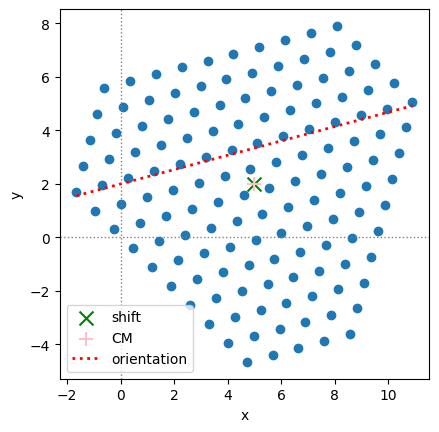

In [3]:
# Let's to a hexagon (truncated if N1!=N2)
c_func = create_cluster_hex

with open('/dev/null', 'w') as outdump: # do not save file anywhere
    pos = c_func('in.hex', outstream=outdump)[:,:2] # For backward compatibility, the position have 6 component, ignore last four

tho = 15 # rotate the cluster [degree]
X0, Y0 = 5, 2 # shift the center of mass
pos = rotate(pos, tho, [0, 0]) # rotate with respect to origin
pos += [X0, Y0] # shift pos

# Plot
plt.scatter(pos[:,0], pos[:,1]) #  Position
plt.scatter(X0, Y0, marker='x', color='green', s=100, label='shift') # Shift
plt.scatter(*np.mean(pos, axis=0), marker='+', color='pink', s=100, label='CM') # CM
xx = np.linspace(min(pos[:,0]), max(pos[:,0])) # Orientation
plt.plot(xx, Y0+xx*tan(tho*pi/180), lw=2, ls=':', color='red', label='orientation')
plt.legend()
plt_cosmetic(plt.gca())
plt.show()

### Do all shapes

Now that we are familiar with how to create and manipulate a cluster, let's try all standard shapes.

To make more interesting, let's also add a crystal basis to the simple lattice defined at the beginning.
The starting point is a classic: the honeycomb lattice. Once a basis is defined, the only thing to do is to repeat it at each lattice point. The functino ```add_basis``` is a convenient shortcut for this.

Cluster Circle of size N=146


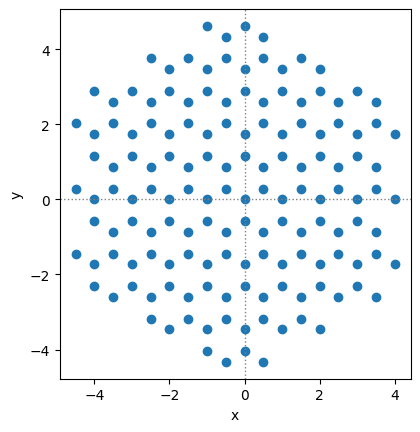

Cluster Hexagon of size N=434


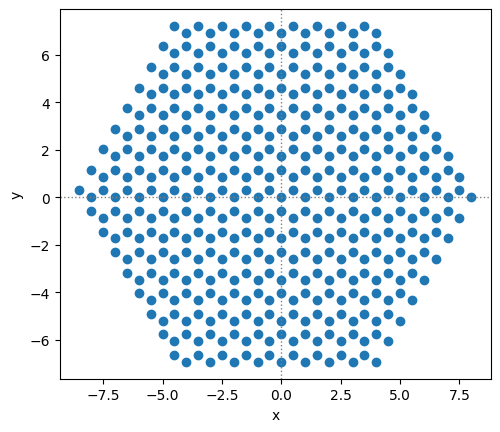

Cluster Rectangle of size N=186


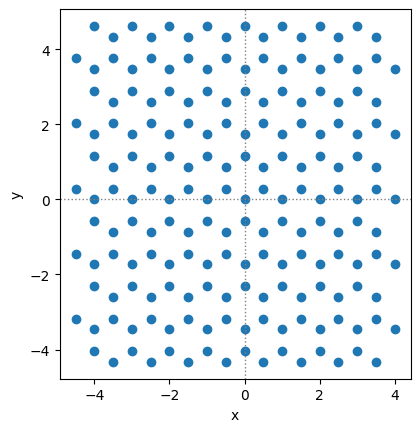

Cluster Triangle of size N=230


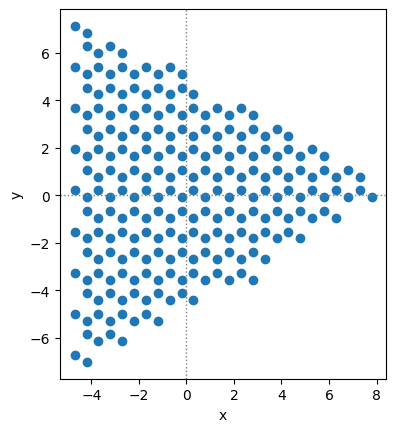

In [4]:
shapes = ['Circle', 'Hexagon', 'Rectangle', 'Triangle']
funcs = [create_cluster_circle, create_cluster_hex, create_cluster_rect, create_cluster_tri]
N1, N2 = 9, 9 # Size
for shape, f in zip(shapes, funcs):
    pos, _ = cluster_inhex_Nl(N1, N2, a1, a2, clgeom_fname='/dev/null', cluster_f=f)
    # Honeycomb
    cl_basis = [[0,0], [-0.5, 0.28867513]]
    pos = add_basis(pos, cl_basis)
    N = pos.shape[0] # Now there are more points in the cluster.
    print("Cluster %s of size N=%i" % (shape, N))
    plt.scatter(pos[:,0], pos[:,1])
    plt_cosmetic(plt.gca())
    plt.show()

### Test loading from params

The parameter to create a cluster can also be stored in a dictionary and parsed by the ```cluster_from_params``` function, which essentially performs the operation in the cells above

Cluster circle of size N=307


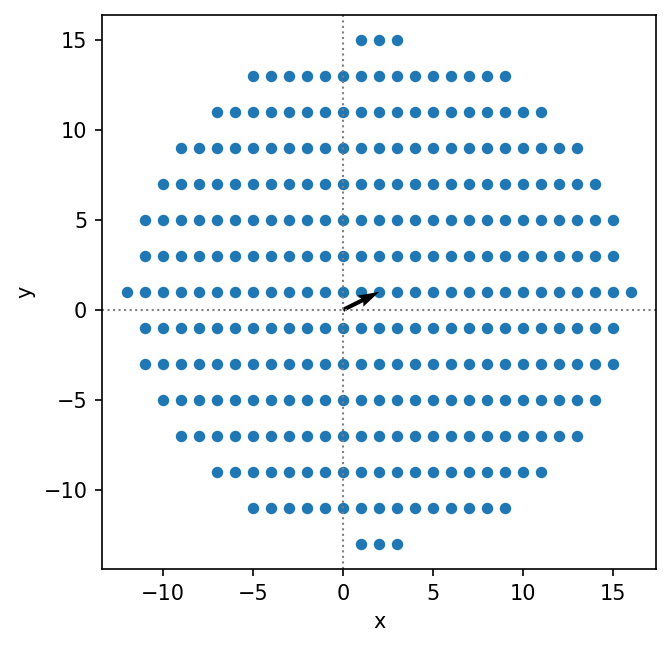

In [5]:
# Cluster parameters from dictionary
from tool_create_cluster import cluster_from_params

poly_points = np.array([[0,0], [15,0], [15,5], [5,5], [5,30], [0,30]])
thp, pos_p = 90, [1,20]
poly_points = rotate(poly_points, thp) + pos_p

params = {
    'a1': [1,0], 'a2': [0,2], # rectangular lattice
    'cl_basis': [[0,0]], # No basis
    'cluster_shape': 'circle',
    'N1': 20, 'N2': 20,
    'theta': 0, 'pos_cm': [2, 1]
}

# Create the cluster
pos = cluster_from_params(params)
N = pos.shape[0] # store the number of particles
print("Cluster %s of size N=%i" % (params['cluster_shape'], N))

# It's more convenient to return a cluster in the origin, then shift and rotate outside of the function
pos = rotate(pos, params['theta']) + params['pos_cm']

plt.scatter(pos[:,0], pos[:,1], s=20)
plt.quiver(0,0, *params['pos_cm'], angles='xy', scale_units='xy', scale=1)
plt_cosmetic(plt.gca())
plt.gcf().set_dpi(150)
plt.show()

### Load from POSCAR

To model real materials, it is convenient to have an interface to other formats.
A useful one is [VASP POSCAR](https://www.vasp.at/wiki/index.php/POSCAR) file, since it containes the lattice and basis, which is all we need.

You can load a geometry from a poscar using the ```params_from_poscar``` function.
The function returns the dictionary parameters that can then be used by other functions to create a cluster.

Since we deal with 2D systems, the POSCAR has to contain the information in the right way:
 - relevant 2D periodicity should be in first two lattice vectors $\mathbf{a},\mathbf{b}$, i.e. $\mathbf{c}\propto (0,0,1)$
 - all information on $z$ component of basis vectors will be lost: the whole geometry is projected to the 2D plane. You can select a z coordinate to cut the geometry, but the best practice would be to do it outside.
 
The function ```params_from_poscar``` is a wrapper of ```params_from_ASE```, if you are alrady working in a python environemnt, you don't need to save a file, use the second function.
Hence, you need a working installation of [ASE](https://wiki.fysik.dtu.dk/ase/) to use this function .

             a1: [1.5951578479909057, -2.7628944388124803]
             a2: [1.5951578479909057, 2.7628944388124803]
       cl_basis:
                 [1.595157847990906, -0.9209648129374934]
z coordiantes ignored: [2.15486663]
Cluster hexagon of size N=61


tool_create_cluster: Selcted 1 atoms at z: [2.15486663]


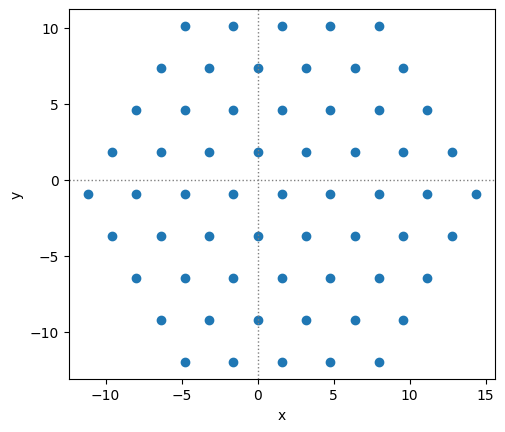

In [6]:
from tool_create_cluster import params_from_poscar

poscar_params, pos_z = params_from_poscar('./data/MoS2.poscar', cut_z=2.5)
# Print the loaded file
for k,v in poscar_params.items():
    if type(v)==list:
        if type(v[0])==list:
            print("%15s:" % k)
            for vv in v:
                print(" "*16, "%-35s" % vv)
        else: print("%15s: %35s" % (k,v))
    else: print("%15s: %35s" % (k,v))
print("z coordiantes ignored:", pos_z)
params = { **poscar_params, **{'cluster_shape': 'hexagon','N1': 5,'N2': 5}}

pos = cluster_from_params(params)
N = pos.shape[0]
print("Cluster %s of size N=%i" % (params['cluster_shape'], N))

plt.scatter(pos[:,0], pos[:,1])
plt_cosmetic(plt.gca())
plt.show()

### Cluster from Polygon shape

Sometimes you want to match an exact experimental cluster or test the behaviour of peculiar shape, then it is convenient to be able to encode arbitrary shapes.
Since we work on computers, an arbitrary shape, is going to be a polygon.
To handle polygons, we use the [Shapely](https://github.com/shapely/shapely) package.
The polygon is defined by its vertices.

In [7]:
from shapely.geometry import Polygon
from shapely.plotting import patch_from_polygon

Let's look at some examples

#### Circle

In [8]:
t = np.linspace(0,1)
xc0, yc0 = np.cos(2*pi*t), np.sin(2*pi*t)
poly = Polygon(np.stack((xc0,yc0), axis=1))
poly_points = np.asarray(poly.exterior.coords)

#### Square

In [9]:
pp = np.array([
    [-1,-1],
    [1,-1],
    [1,1],
    [-1, 1]
])
poly = Polygon(pp)
poly_points = np.asarray(poly.exterior.coords)

#### L-shape

In [10]:
pp = np.array([
    [0,0],
    [3,0],
    [3,1],
    [1,1],
    [1,7],
    [0,7]
])
poly = Polygon(pp)
poly_points = np.asarray(poly.exterior.coords)

#### Show polygon

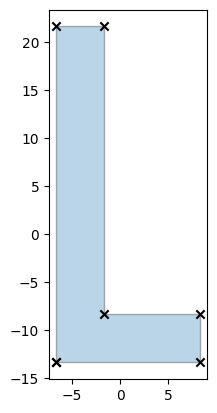

In [11]:
# Enlarge the points and shift to origin
points = poly_points*5
points -= np.mean(points[:-1], axis=0) # Last point is repeated, skip
cm = np.mean(points[:-1], axis=0)
poly = Polygon(points)
# Get points to use later
points = np.asarray(poly.exterior.coords)
# Show
patch0 = patch_from_polygon(poly, facecolor='tab:blue', alpha=0.3, zorder=0)
plt.gca().add_patch(patch0)
plt.scatter(points[:,0], points[:,1], c='k', marker='x')
plt.gca().set_aspect('equal')
plt.show()

#### Mask lattice with polygon

To go from the polygon to a flake, we generate a lattice within the bounding box of the polygon, i.e. we ecompass it.
Than we take all the lattice points within the polygon. Thankfully Shapely has a method for it.

The process can work the other way around as well: eliminate from a given lattice all the points within the polygon, see below.

cluster of size N=259
Cluster cm [-1.88262843 -1.76796246]


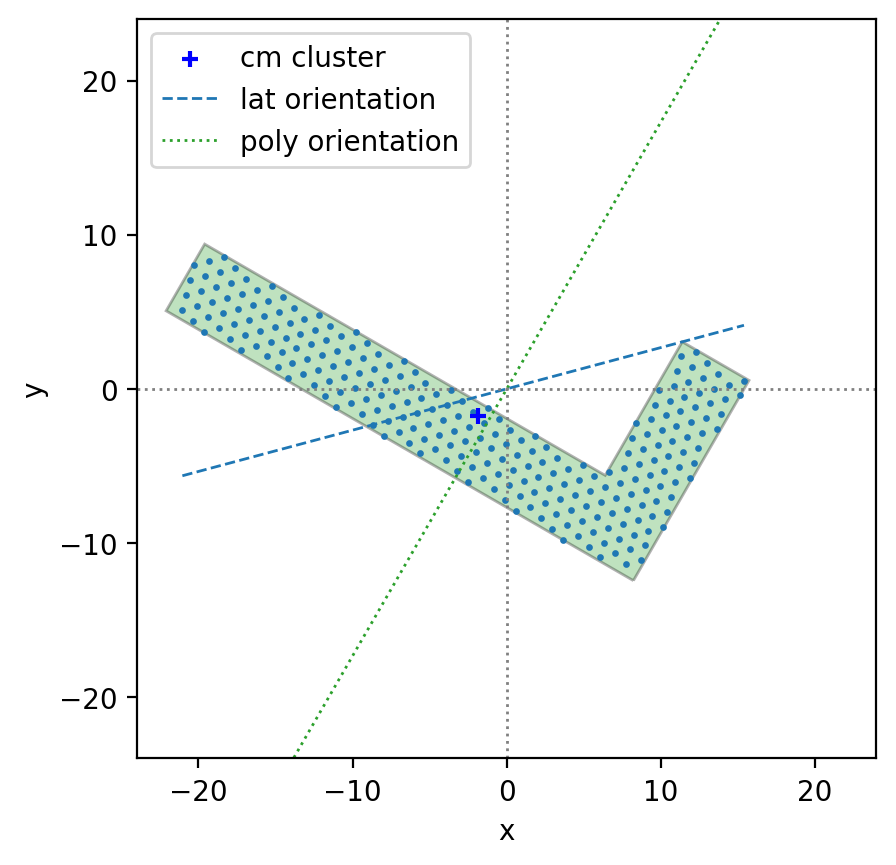

In [12]:
from tool_create_cluster import cluster_poly, get_poly
import misc
## ----------- POLYGON -------------
tho = 60 # degree ! rotation of mask, NOT of lattice
poly = get_poly(points, tho=tho, shift=[0.,0.], cm=False, scale=1)
# Show it
patch0 = patch_from_polygon(poly, facecolor='tab:green', alpha=0.3, zorder=0) # Add shaded area of polygon
plt.gca().add_patch(patch0)

## ----------- MASK LATTICE -------------
params = {
    'a1': [1,0], 'a2': [-1/2,sqrt(3)/2], # triangular lattice
    'cl_basis': [[0,0]], # No basis
    'N1': 20, 'N2': 20,
    'theta': 15, 'pos_cm': [0,0]
}
 # misaligned polygon and lattice
pos = cluster_poly(poly, params, direction=0) # direction=0: inside / direction=1: outside
N = pos.shape[0] # masked-cluster size
print('cluster of size N=%i' % N)
plt.scatter(pos[:,0], pos[:,1], s=2)
cm = np.mean(pos, axis=0)
print('Cluster cm', cm)
plt.scatter(cm[0], cm[1], marker='+', c='blue', label='cm cluster')
## -----------

# Show orientations
### Lattice
xx = np.linspace(np.min(pos[:,0]), np.max(pos[:,0]))
plt.plot(xx, xx*tan(params['theta']*pi/180), lw=1, ls='--', color='tab:blue', label='lat orientation')
### Polygon
xx = np.linspace(np.min(pos[:,0]), np.max(pos[:,0]))
plt.plot(xx, xx*tan(tho*pi/180), lw=1, ls=':', color='tab:green', label='poly orientation')

# Cosmetics
side = 1.1*np.max(np.linalg.norm(pos, axis=1))
plt.ylim([-side, side])
plt.xlim([-side, side])
plt.legend()
plt_cosmetic(plt.gca())
plt.gcf().set_dpi(200)
plt.show()

#### Polygon from params
You can also load a polygon shape from a parameter file, just like any other shape.
The parameter file needs to contain the vertices of the polygon.
 
Let's use this example to show also how to cut holes in a flake! Reverse the "direction" of masking.

Cluster circle of size N=4057


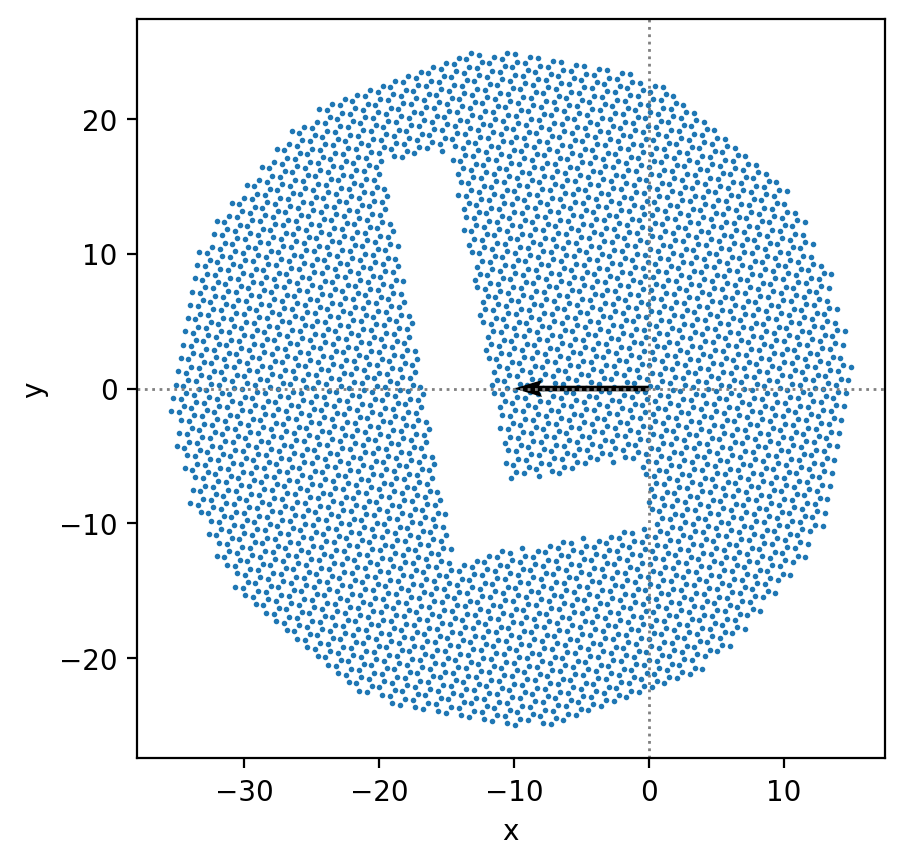

In [13]:
from tool_create_cluster import cluster_from_params

# Define the polygon from its vertices. Rotations and shift can be defined here or in the parameters
poly_points = np.array([[0,0], [15,0], [15,5], [5,5], [5,30], [0,30]], dtype=float)
poly_points -= np.mean(poly_points, axis=0) # CM to origin

params = {
    'a1': [1,0], 'a2': [-1/2, sqrt(3)/2],
    'cl_basis': [[0,0], [-0.5, 0.28867513]],
    'cl_poly': list(poly_points),
    'cluster_shape': 'polygon',
    'direction': 1, # use polygon to cut a whole    
    'masked_shape': 'circle', # cut hole in a circle
    'N1': 50, 'N2': 50,
    'theta': 10, 'pos_cm': [-10, 0] 
}

pos = cluster_from_params(params)
pos -= np.mean(pos, axis=0) # CM to origin
N = pos.shape[0]
print("Cluster %s of size N=%i" % (params['cluster_shape'], N))

pos = rotate(pos, params['theta']) + params['pos_cm']

plt.scatter(pos[:,0], pos[:,1], s=1)
plt.quiver(0,0, *params['pos_cm'], angles='xy', scale_units='xy', scale=1)
plt_cosmetic(plt.gca())
plt.gcf().set_dpi(200)
plt.show()